In [142]:
import string
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

In [30]:
sys.setrecursionlimit(500000)

In [21]:
def flatten_list(t):
    return [item for sublist in t for item in sublist]

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


def load_object(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [3]:
name_soup = []

for letter in string.ascii_uppercase:
    url = f'https://en.wikipedia.org/wiki/List_of_painters_by_name_beginning_with_%22{letter}%22'
    name_soup.append(bs(requests.get(url).content))

In [6]:
save_object(name_soup, "name_soup.pkl")

In [9]:
selector = '#mw-content-text > div.mw-parser-output > div.div-col > ul > li'

entry_list = []

for soup in name_soup:
    entry_list.append(soup.select(selector))

entry_list = flatten_list(entry_list)

In [206]:
df_dct = {
    "name": []
    , "url": []
    }

for entry in entry_list:
    df_dct['name'].append(entry.a.text)
    df_dct['url'].append(entry.a.get('href'))

df = pd.DataFrame(df_dct)
df.drop_duplicates(inplace=True)

In [207]:
name_list = df['name'].to_list()

In [196]:
graph_df_dct = {
    "source": []
    , "target": []
}

for i in range(len(df)):
    source, page = df.loc[i]
    wiki_url = f'https://en.wikipedia.org{page}'
    soup = bs(requests.get(wiki_url).content).text

    names = name_list.copy()
    names.remove(source)

    for target in names:
        if target in soup:
            graph_df_dct["source"].append(source)
            graph_df_dct["target"].append(target)    

    if i%50 == 0:
        print(i)

graph_df = pd.DataFrame(graph_df_dct)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450


In [210]:
save_object(graph_df, 'graph_df.pkl')

In [252]:
mask = graph_df.groupby('source')['source'].transform('count')

data = graph_df[mask > 4]

# mask = data.groupby('target')['target'].transform('count')

# data = data[mask > 20]

G = nx.from_pandas_edgelist(data, source="source", target="target")

In [323]:
G = nx.from_pandas_edgelist(graph_df, source="source", target="target")

In [329]:
to_be_removed = [0]

while to_be_removed != []:

    to_be_removed = [x for x in G.nodes() if G.degree(x) <= 2]

    for x in to_be_removed:
        G.remove_node(x)

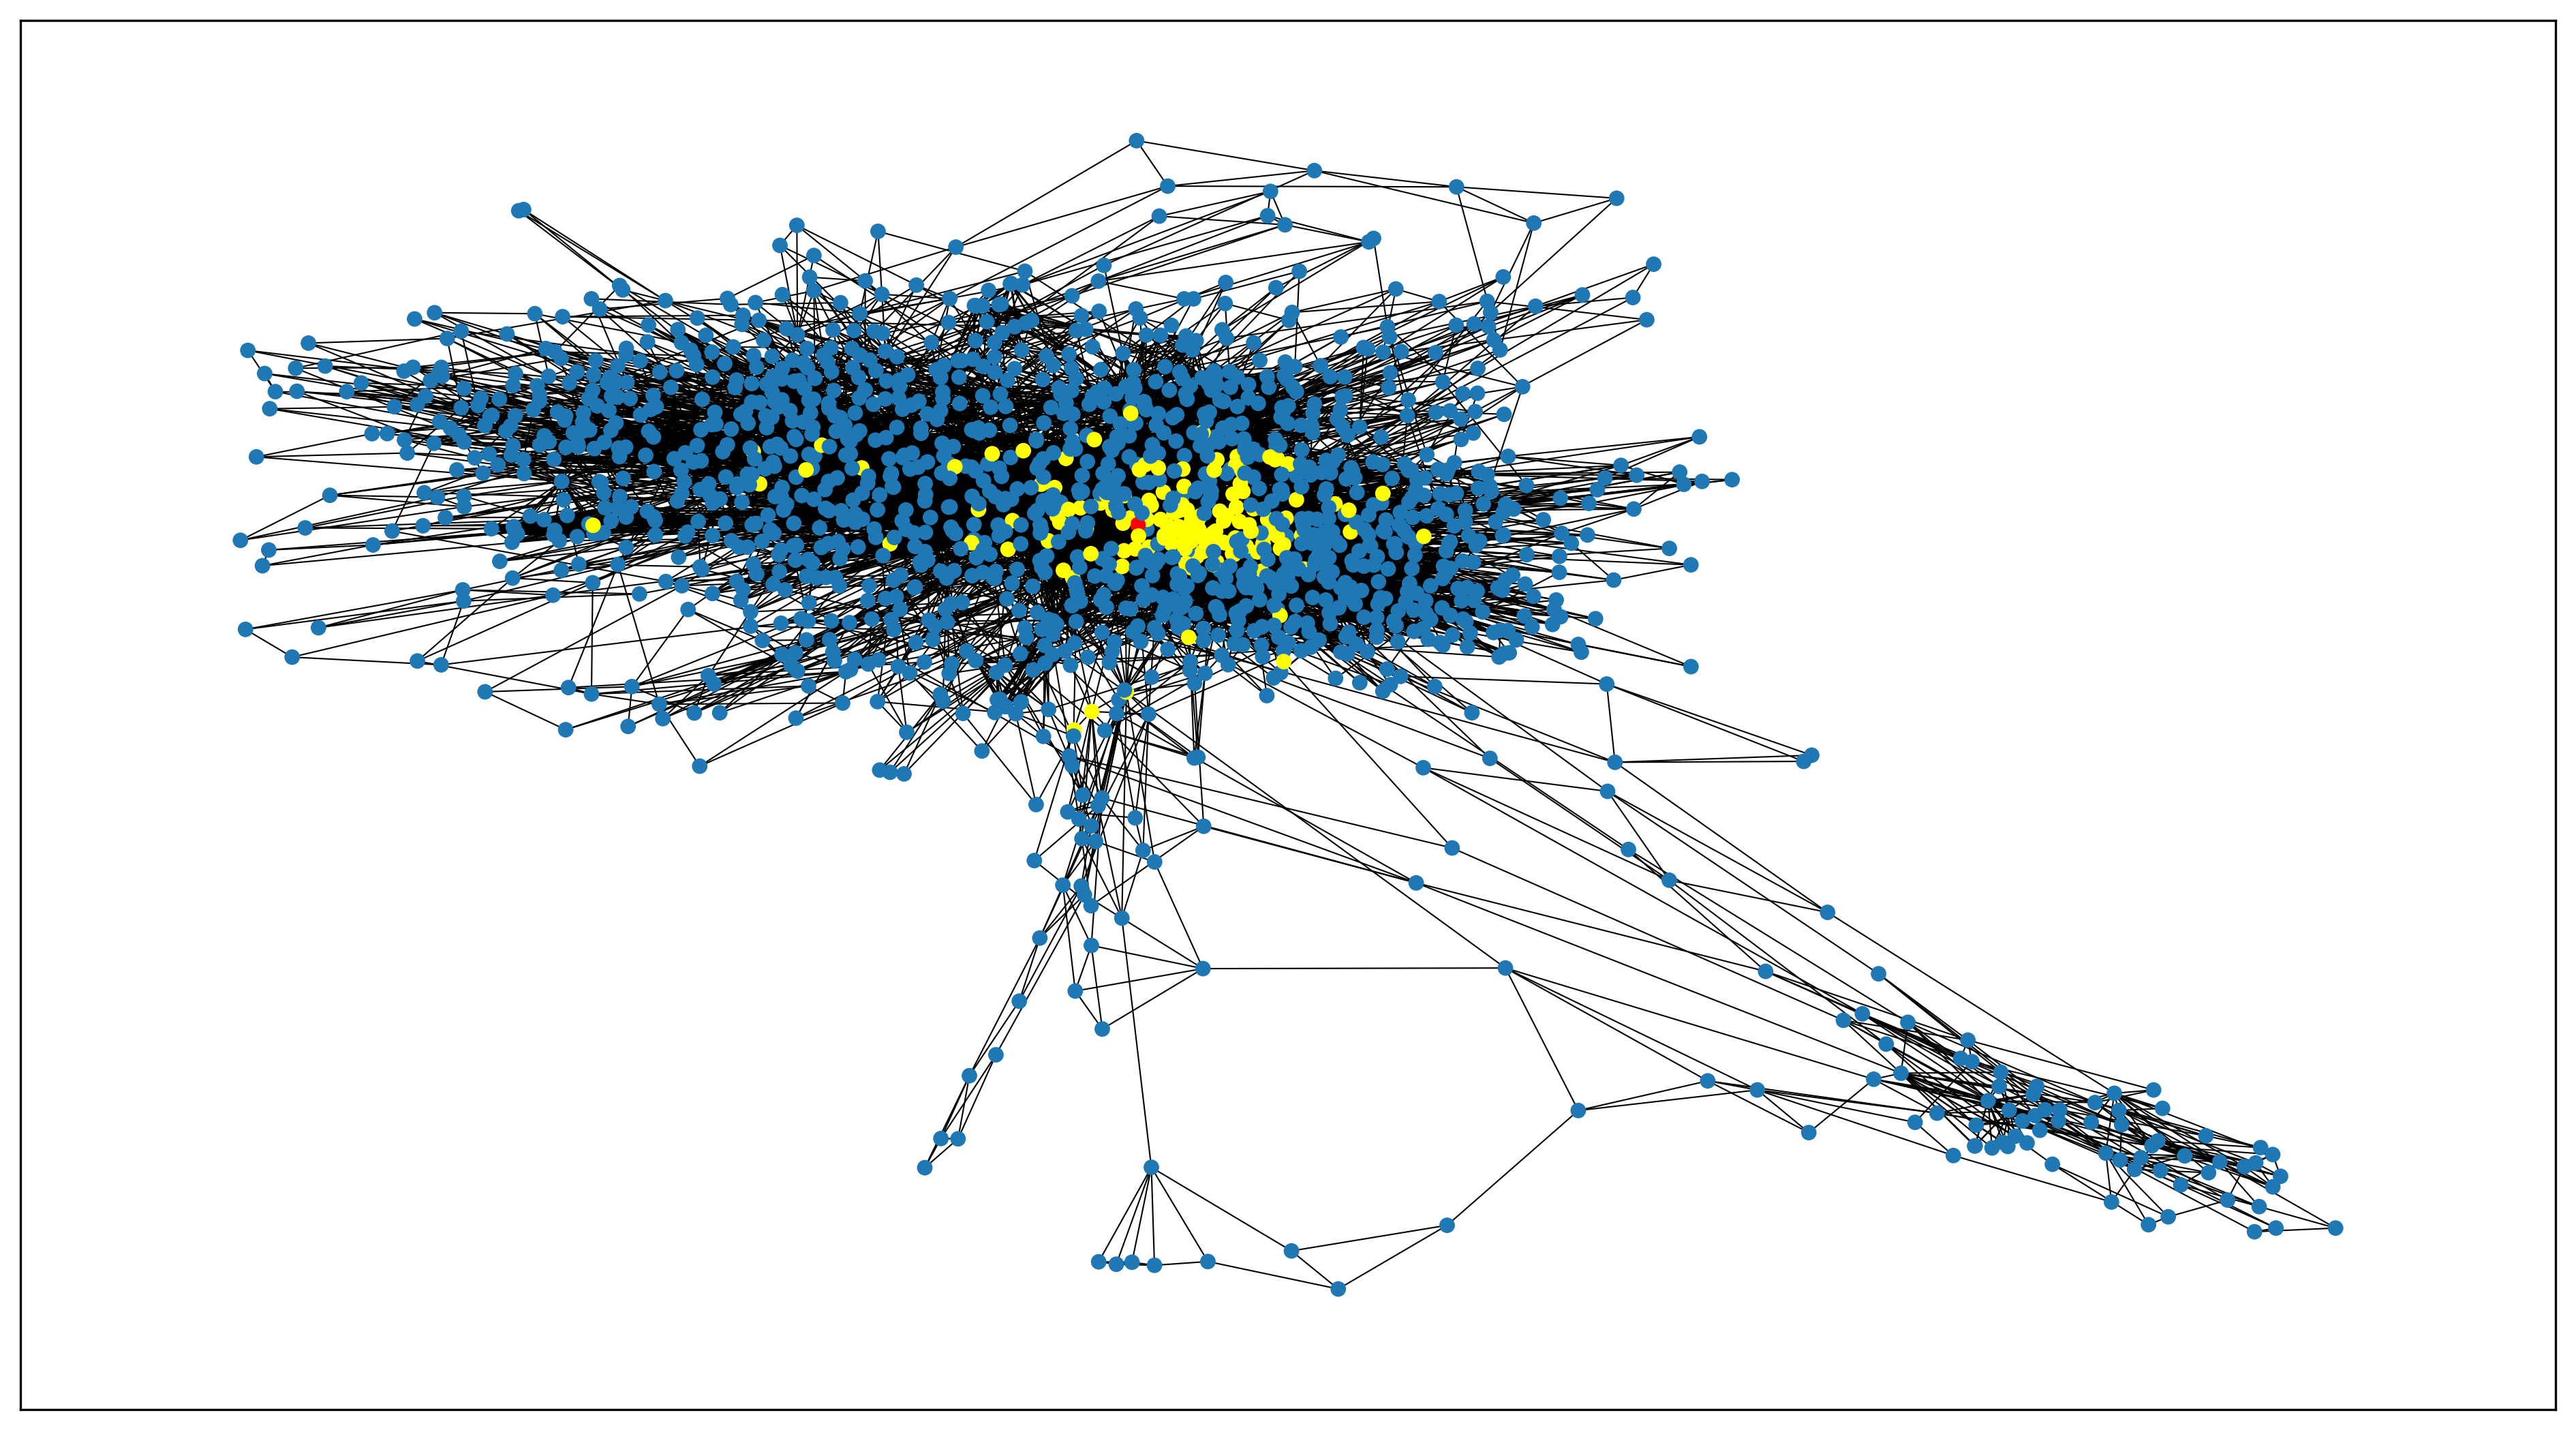

In [357]:
plt.figure(figsize=(16,9), dpi=300)
pos = nx.spring_layout(G)
# nx.draw(G)
node_name = 'Vincent van Gogh'
connected = nx.descendants_at_distance(G, node_name, 1)
color_map = ['red' if node == node_name else 'yellow' if node in connected else '#1f78b4' for node in G]
nx.draw_networkx_nodes(G, pos=pos, node_size=20, node_color=color_map)
nx.draw_networkx_edges(G, pos=pos, width=0.5)
# nx.draw_networkx_labels(G, pos=pos)
plt.show()

In [178]:
net = Network(height='800px', width='1200px')

net.from_nx(G)
net.show_buttons()

net.show('example.html')